In [3]:
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

---------------------------------------------------------------------------------------


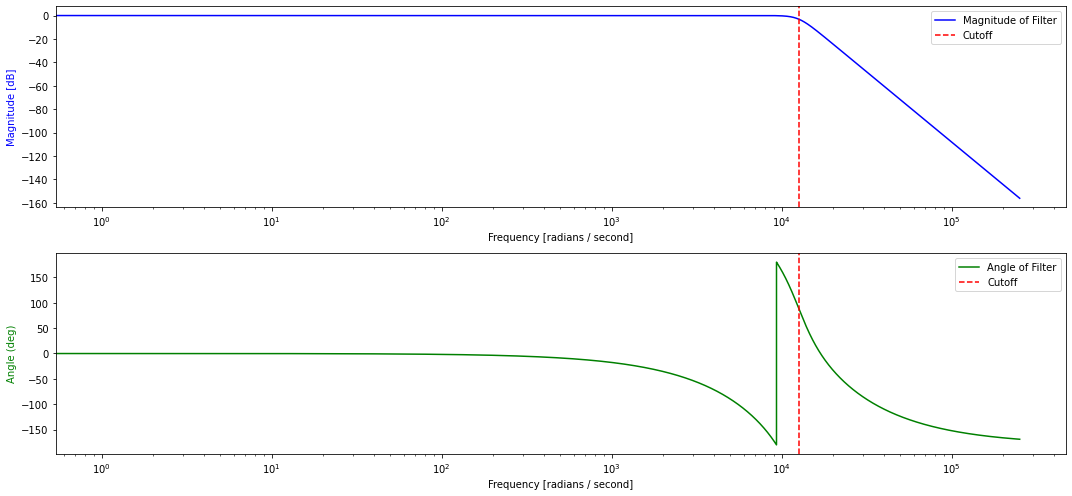

,Signal Power,Noise Power,SNR
2 bands,40.757045,-22.434258,63.191303
4 bands,40.757045,-19.389230,60.146275


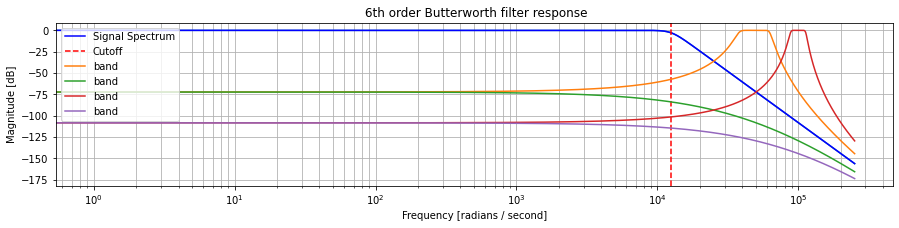

[1.00000000e+00 4.85527277e+04 1.17868368e+09 1.81406467e+13
 1.86130267e+17 1.21074613e+21 3.93785014e+24]
[3.93785014e+24]
---------------------------------------------------------------------------------------


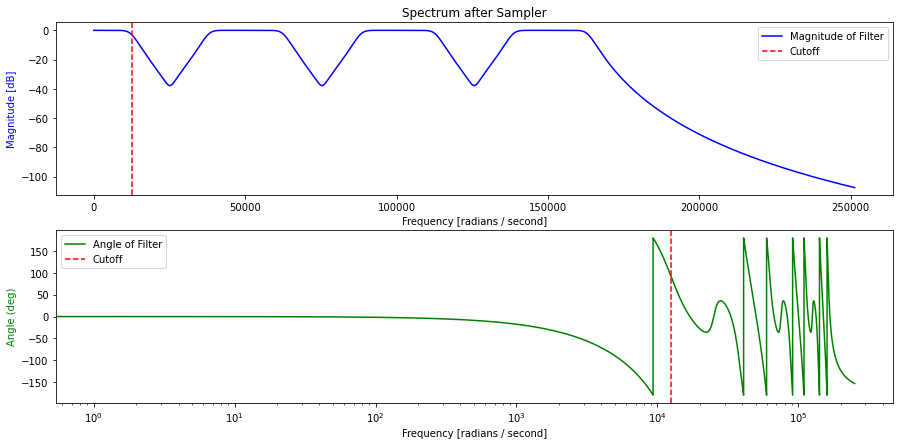

In [113]:
B_RAD = 2*np.pi*2000 # 3dB frequency of filter
ws = 4*B_RAD         # sampling frequency in radians (frequency shifts due to aliasing) 8k * 2 * pi

N = int(20*B_RAD)    # Number of slices (instead of integration)

bands = 2           # Number of bands


#----------------------------------------- Make tables pretty ------------------------------------------ 
def add_border(df):
    return df.style.set_table_styles([{'selector': 'table', 'props': [('border', '1px solid black')]}])
#------------------------------------------------------------------------------------------------------- 

def SignalPower(h, delta_w):
    power = 0   
    cut_index = 10
    for i in range(len(delta_w)):
        if(20*np.log10(h[i]) >= -3):
            power = power + abs(h[i])**2
            
            #Find out which index of the array represents the cutoff frequency
            if(min(h[i] - (1/np.sqrt(2)), cut_index != cut_index)):
                cut_index = i
    return power, cut_index

def makeImag(arr):
    newArray = np.zeros(len(arr), complex)
    for i in range(len(arr)):
        newArray[i]= arr[i]*complex(0,1)
    return newArray

def NoiseSpectrum(w_shift, a, b, order, freqs):
    newfreqs = makeImag(freqs - w_shift)
    d = np.empty((0, len(freqs)))
    
    # Create an where each element is a term of the denominator times the array of frequencies
    for i in range(order + 1):
        d = np.vstack((d, a[i]*(newfreqs)**(order - i)))      
    
    
    # Add all the terms together for each frequency. This condenses the matrix in to a single array
    den_sum = np.zeros(len(freqs))
    for i in range(len(d)):
        den_sum = den_sum + d[i,:]
    h = b[0] * (den_sum**-1)
    
    return h
    
def NoiseH(cut_index, w_shift, a, b, order, freqs, plot):
    newfreqs = makeImag(freqs - w_shift)
    d = np.empty((0, len(freqs)))
    
    # Create an where each element is a term of the denominator times the array of frequencies
    for i in range(order + 1):
        d = np.vstack((d, a[i]*(newfreqs)**(order - i)))      
    
    
    # Add all the terms together for each frequency. This condenses the matrix in to a single array
    den_sum = np.zeros(len(freqs))
    for i in range(len(d)):
        den_sum = den_sum + d[i,:]
    h = b[0] * (den_sum**-1)
    
    if(plot == True):
    #------------------------------- Plot stuff --------------------------------   
        #plt.plot(freqs, 20 * np.log10(abs(h)), c = 'Purple')
        plt.semilogx(abs(freqs), 20*np.log10(abs(h)), label="band")
        #plt.title(' shifted order Butterworth filter response')
        plt.xlabel('Frequency [radians / second]')
        plt.ylabel('Magnitude [dB]')
        plt.grid(which='both', axis='both')
        plt.legend()
    
 #---------------------------------------------------------------------------  
    return h[: cut_index]

# There are numBands * 2 bands. That's becasue there is the positive side, and the corresponding negative
def NoisePower(cut_index, w_shift, a, b, order, freqs, numBands, plot):
    sum_of_f_noise = np.zeros(cut_index , complex)
    
    for i in range(numBands):
        sum_of_f_noise += NoiseH(cut_index, (i+1)*w_shift, a, b, order, freqs, plot)
        sum_of_f_noise += NoiseH(cut_index, -(i+1)*w_shift, a, b, order, freqs, plot)
    
    power_in_bands = np.sum(np.abs(sum_of_f_noise) ** 2)
    
    return power_in_bands
    
    
def analyzeFilter(order, band_rad, n, w_sample):
    b, a = signal.butter(order, band_rad, 'low', analog=True)
    freqs = np.linspace(0, N, N+1)

    w, h = signal.freqs(b, a, freqs)
 #------------------------------- Plot stuff --------------------------------     
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_figwidth(15)
    fig.set_figheight(7)
    ax1.semilogx(w, 20 * np.log10(abs(h)), c="Blue", label = "Magnitude of Filter")
    ax1.axvline(B_RAD, color='Red',linestyle='--', label="Cutoff")
    ax1.set_xlabel('Frequency [radians / second]')
    ax1.set_ylabel('Magnitude [dB]', color='Blue')
    ax1.legend()
    ax2.semilogx(w, np.angle(h, deg=True), c="Green", label = "Angle of Filter")
    ax2.axvline(B_RAD, color='Red',linestyle='--', label="Cutoff")
    ax2.set_xlabel('Frequency [radians / second]')
    ax2.set_ylabel('Angle (deg)', color='Green')
    ax2.legend()
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(15, 3))
    #plt.semilogx(w, 20 * np.log10(abs(h)))
    plt.plot(w, 20 * np.log10(abs(h)))
    plt.plot(w, 20 * np.log10(abs(h)), c="Blue", label="Signal Spectrum")
 #---------------------------------------------------------------------------
    ps, cut = SignalPower(h, w)
    
    if(order ==1):
        ord_str = 'st'
    elif(order == 2):
        ord_str = 'nd'
    elif(order == 3):
        ord_str = 'rd'
    else:
        ord_str = 'th'
        
 #------------------------------- Plot stuff --------------------------------     
    plt.title(f' {order}{ord_str} order Butterworth filter response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Magnitude [dB]')
    plt.grid(which='both', axis='both')
    plt.axvline(B_RAD, color='Red',linestyle='--', label="Cutoff") # cutoff frequency
    
 #---------------------------------------------------------------------------
    plot_something = False
    pn = NoisePower(cut, w_sample, a, b, order, w, 1, plot_something)
    n_band = [pn]
    snr = [10*np.log10(ps/pn)]
    pdindex = ["2 bands"]
    for i in range(bands-1):
        if(i == bands - 2):
            plot_something = True
            
        pn = pn + NoisePower(cut, w_sample, a, b, order, w, i+2, plot_something)
        n_band.append(pn)
        snr.append(10*np.log10(ps/pn))
        pdindex.append(f'{(i+2)*2} bands')
    #SNR = 10*np.log10(ps/pn)
    
    #print('SNR = ', SNR)
    
    dataset = {
      'Signal Power': np.ones(len(n_band)) * 10*np.log10(ps),
      'Noise Power': 10*np.log10(n_band),
      'SNR': snr
    }

    frame = pd.DataFrame(dataset, pdindex)
    display(add_border(frame))
#------------------------------- Plot stuff --------------------------------     
    plt.legend()
    plt.show()
 #---------------------------------------------------------------------------
    return ps, h, w, a, b


#p1, h1, w1, a, b = analyzeFilter(1, B_RAD, N, ws)
#print('---------------------------------------------------------------------------------------')
#p3, h3, w3, a, b = analyzeFilter(3, B_RAD, N, ws)
print('---------------------------------------------------------------------------------------')
order = 6
p6, h6, w6, a, b = analyzeFilter(6 , B_RAD, N, ws)
print(a)
print(b)
print('---------------------------------------------------------------------------------------')


# Graph the spectrum after the sampler
l = np.zeros(len(h6), complex)
freqs = np.linspace(0, N, N+1)

for i in range(bands+1):
    
    l += NoiseSpectrum((i + 1) * ws, a, b, order, freqs)
    l += NoiseSpectrum(-(i + 1) * ws, a, b, order, freqs)
    
h6 += l



fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figwidth(15)
fig.set_figheight(7)

ax1.set_title('Spectrum after Sampler')
ax1.plot(w6, 20 * np.log10(abs(h6)), c="Blue", label = "Magnitude of Filter")
ax1.axvline(B_RAD, color='Red',linestyle='--', label="Cutoff")
ax1.set_xlabel('Frequency [radians / second]')
ax1.set_ylabel('Magnitude [dB]', color='Blue')
ax1.legend()


ax2.semilogx(w6, np.angle(h6, deg=True), c="Green", label = "Angle of Filter")
ax2.axvline(B_RAD, color='Red',linestyle='--', label="Cutoff")
ax2.set_xlabel('Frequency [radians / second]')
ax2.set_ylabel('Angle (deg)', color='Green')
ax2.legend()




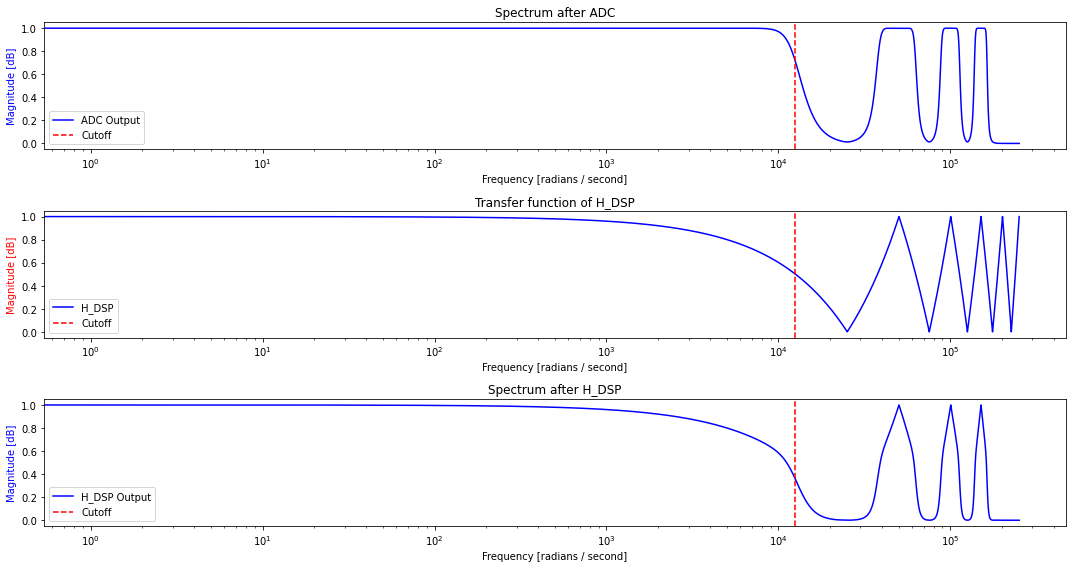

In [62]:
dspH = np.abs(h6)

def quantize(signal, bits):
    m = 2 ** bits
    l = 1/m
    
    for i in range(len(signal)):
        signal[i] = l * round( signal[i] / l)

    return signal

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_figwidth(15)
fig.set_figheight(8)

q_signal = quantize(abs(h6), 12)

h_dsp = np.ones(N + 1)

direction = 1/(8000*np.pi)


h_dsp[i] = 1
for i in range(len(h_dsp) - 1):
    
    h_dsp[i+ 1] = h_dsp[i] - direction
    
    if(i % (round(8000*np.pi)) == 0 and i > 0):
        direction = -direction
    #value = value - (direction)
    

ax1.set_title('Spectrum after ADC')
ax1.semilogx(w6, q_signal, c="Blue", label = "ADC Output")
ax1.axvline(B_RAD, color='Red',linestyle='--', label="Cutoff")
ax1.set_xlabel('Frequency [radians / second]')
ax1.set_ylabel('Magnitude [dB]', color='Blue')
ax1.legend()

ax2.set_title('Transfer function of H_DSP')
ax2.semilogx(w6, h_dsp, c="Blue", label = "H_DSP")
ax2.axvline(B_RAD, color='Red', linestyle='--', label="Cutoff")
ax2.set_xlabel('Frequency [radians / second]')
ax2.set_ylabel('Magnitude [dB]', color='Red')
ax2.legend()

h_dsp = h_dsp * q_signal

ax3.set_title('Spectrum after H_DSP')
ax3.semilogx(w6, h_dsp, c="Blue", label = "H_DSP Output")
ax3.axvline(B_RAD, color='Red', linestyle='--', label="Cutoff")
ax3.set_xlabel('Frequency [radians / second]')
ax3.set_ylabel('Magnitude [dB]', color='Blue')
ax3.legend()
plt.tight_layout()
plt.show()

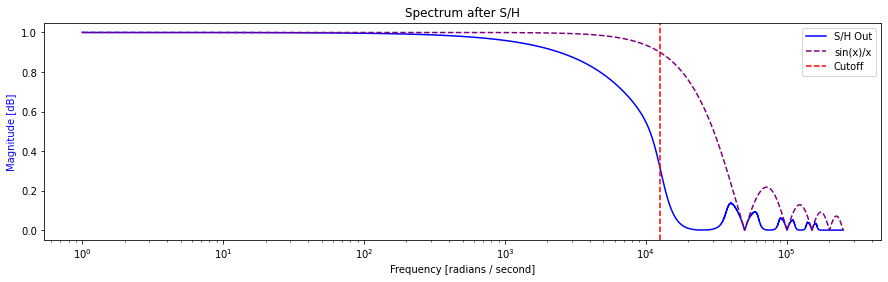

In [63]:
dac_h = quantize(h_dsp, 12)
x = w6
x[0] = 1
pifts = (np.pi/ws)*x
sinc = abs(np.sin(pifts) * (1/pifts))
sh_h = np.zeros(len(dac_h))
sh_h[0] = 1
sh_h[1:] = dac_h[1:]*sinc[1:]

fig, (ax) = plt.subplots(1, 1)
fig.set_figwidth(15)
fig.set_figheight(4)
ax.set_title('Spectrum after S/H')
ax.semilogx(w6, abs(sh_h), c = 'blue', label = "S/H Out")
ax.semilogx(w6, sinc, '--', c = 'purple', label = 'sin(x)/x')
ax.axvline(B_RAD, color='Red', linestyle='--', label="Cutoff")
ax.set_xlabel('Frequency [radians / second]')
ax.set_ylabel('Magnitude [dB]', color='Blue')
plt.legend()
plt.show()

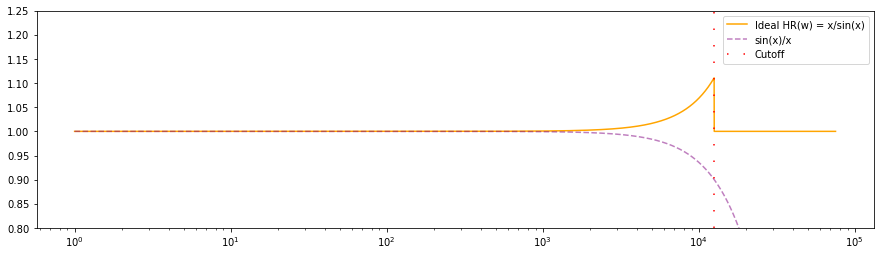

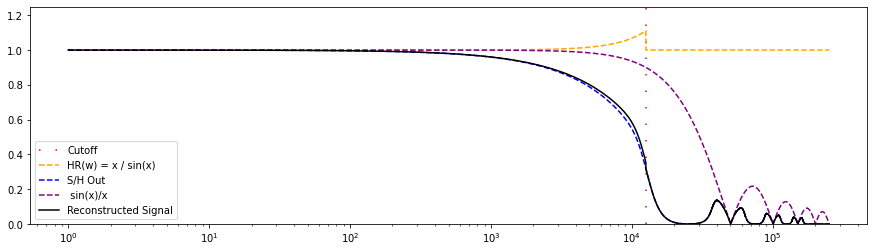

In [64]:
sh_r = sinc ** -1  # Reconstruction Filter
sh_r[int(B_RAD):] = np.ones(len(sh_r) - int(B_RAD))
zoom_length = 6* int(B_RAD)

plt.figure().set_figwidth(15)

plt.semilogx(w6[:zoom_length], sh_r[:zoom_length], c = 'orange', label = 'Ideal HR(w) = x/sin(x)')
plt.semilogx(w6[:zoom_length], sinc[:zoom_length], '--', c = 'purple', label = 'sin(x)/x', alpha = 0.5)
plt.axvline(B_RAD, color='Red', linestyle=(0, (1, 10)), label="Cutoff")
plt.ylim(0.8,1.25)
plt.legend()
plt.show()

y_out = sh_r * sh_h

c
plt.axvline(B_RAD, color='Red', linestyle=(0, (1, 10)), label="Cutoff")
plt.semilogx(w6, sh_r, '--', c = 'orange', label = 'HR(w) = x / sin(x)')
plt.semilogx(w6, sh_h, '--', c = 'blue', label = 'S/H Out')
plt.semilogx(w6, sinc, '--', c = 'purple', label = ' sin(x)/x')

plt.semilogx(w6, y_out, c = 'black', label = 'Reconstructed Signal')
plt.ylim(0, 1.25)
plt.legend()
plt.show()

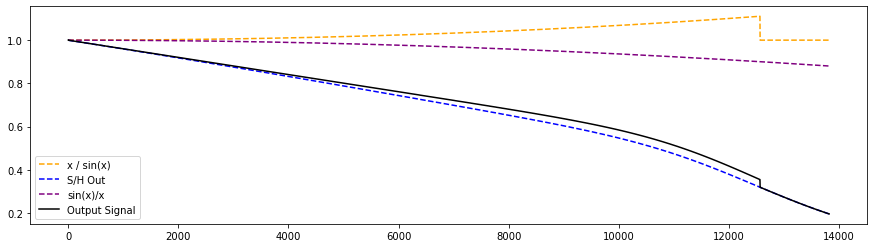

In [65]:
LENGTH = int(1.1 * B_RAD)
plt.figure().set_figwidth(15)
plt.plot(w6[:LENGTH], sh_r[:LENGTH], '--', c = 'orange', label = 'x / sin(x)')
plt.plot(w6[:LENGTH], sh_h[:LENGTH], '--', c = 'blue', label = 'S/H Out')
plt.plot(w6[:LENGTH], sinc[:LENGTH], '--', c = 'purple', label = 'sin(x)/x')
plt.plot(w6[:LENGTH], y_out[:LENGTH], c = 'black', label = 'Output Signal')

plt.legend()
plt.show()

w = (Xt X)^-1 y

In [66]:
N = int(0.3825*B_RAD)

half_N = int(N/2)

M = 3

X = np.ones(N).reshape(N, 1)
best_y = np.array(sh_r[:N]).reshape(N,1) ** - 1
best_y = best_y


input_array = np.array(w6[:N]).reshape(N,1)

for i in range(M-1):
    X = np.hstack((X, input_array ** (i+1)))

phi = X.T.dot(X)

inv = np.linalg.pinv(phi)

w = inv.dot(X.T)

w = w.dot(best_y)
print(w)

[[ 1.00000576e+00]
 [-1.28405298e-08]
 [-6.46023633e-10]]


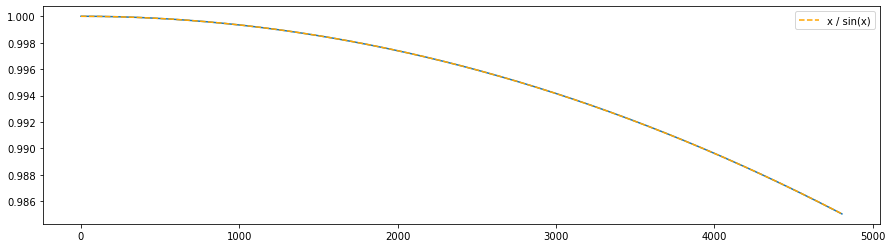

In [67]:
new_h = np.zeros(len(w6))


new_h = w[0]* np.ones(len(w6))
for i in range(1, M):
    new_h = new_h + (w[i] * (w6 ** (i)))


plt.figure().set_figwidth(15)
plt.plot(w6[:N], new_h[:N])
plt.plot(w6[:N], best_y, '--', c = 'orange', label = 'x / sin(x)')



plt.legend()
plt.show()

array([ -3252.41604281+12138.18191913j,  -3252.41604281-12138.18191913j,
        -8885.76587632 +8885.76587632j,  -8885.76587632 -8885.76587632j,
       -12138.18191913 +3252.41604281j, -12138.18191913 -3252.41604281j])

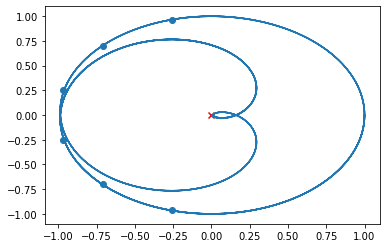

In [101]:
plt.plot(h6.real, h6.imag)
plt.scatter(0, 0, marker='x', c='red')


xx = np.roots(a).real
yy = np.roots(a).imag
plt.scatter(np.roots(a).real * 0.00008, np.roots(a).imag* 0.000079)
np.roots(a)

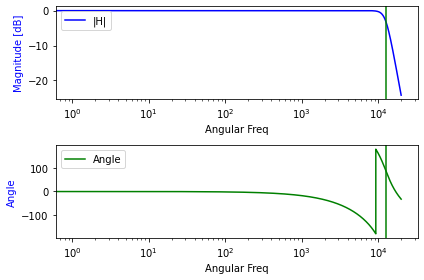

3


In [112]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np



B_RAD = 2*np.pi*2000 # 3dB frequency of filter
ws = 4*B_RAD         # sampling frequency in radians (frequency shifts due to aliasing) 8k * 2 * pi

N = 20000#enter a number here    # Number of slices (instead of integration)

bands = 2           # Number of bands


b, a = signal.butter(order, B_RAD, 'low', analog=True)
freqs = np.linspace(0, N, N+1) # Creates an array of numbers from 0 to N in N+1 steps

w, h = signal.freqs(b, a, freqs)
 #------------------------------- Plot stuff --------------------------------     
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.semilogx(w, 20*np.log10(abs(h)), c="Blue", label = "|H|")
ax1.axvline(B_RAD, color='green', label="")
ax1.set_xlabel('Angular Freq')
ax1.set_ylabel('Magnitude [dB]', color='Blue')
ax1.legend()
ax2.semilogx(w, np.angle(h, deg=True), c="Green", label = "Angle")
ax2.axvline(B_RAD, color='green', label="")
ax2.set_xlabel('Angular Freq')
ax2.set_ylabel('Angle', color='Blue')
ax2.legend()
plt.tight_layout()
plt.show()

def myFunction(input1, input2):
    print(input1 + input2)

myFunction(1, 2)